In [1]:
# 구글 드라이브 불러오기

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

## Trading Strategies

### Simple Moving Averages

#### Data Import

In [3]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [4]:
raw = pd.read_csv('/content/drive/My Drive/Python_for_Finance/data/tr_eikon_eod_data.csv', index_col=0, parse_dates=True)

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972 entries, 2010-01-04 to 2017-10-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  1972 non-null   float64
 1   MSFT.O  1972 non-null   float64
 2   INTC.O  1972 non-null   float64
 3   AMZN.O  1972 non-null   float64
 4   GS.N    1972 non-null   float64
 5   SPY     1972 non-null   float64
 6   .SPX    1972 non-null   float64
 7   .VIX    1972 non-null   float64
 8   EUR=    1972 non-null   float64
 9   XAU=    1972 non-null   float64
 10  GDX     1972 non-null   float64
 11  GLD     1972 non-null   float64
dtypes: float64(12)
memory usage: 200.3 KB


In [6]:
symbol = 'AAPL.O'

In [7]:
data = (
    pd.DataFrame(raw[symbol])
    .dropna()
    )

#### Trading Strategy

In [8]:
SMA1 = 42
SMA2 = 252

In [9]:
data['SMA1'] = data[symbol].rolling(SMA1).mean()
data['SMA2'] = data[symbol].rolling(SMA2).mean()

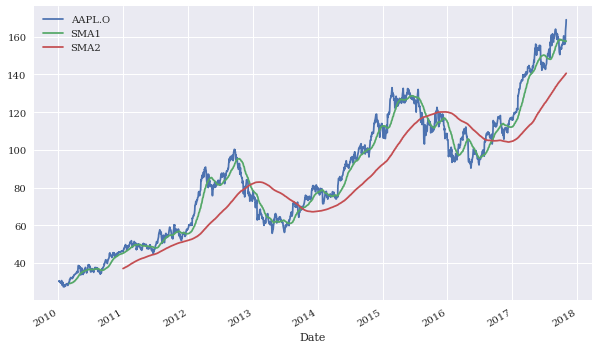

In [10]:
data.plot(figsize=(10, 6));

In [11]:
data.dropna(inplace=True)

In [12]:
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [13]:
data.tail()

,AAPL.O,SMA1,SMA2,Position
Date,,,,
2017-10-25,156.41,157.610952,139.862520,1
2017-10-26,157.41,157.514286,140.028472,1
2017-10-27,163.05,157.517619,140.221210,1
2017-10-30,166.72,157.597857,140.431528,1
2017-10-31,169.04,157.717857,140.651766,1


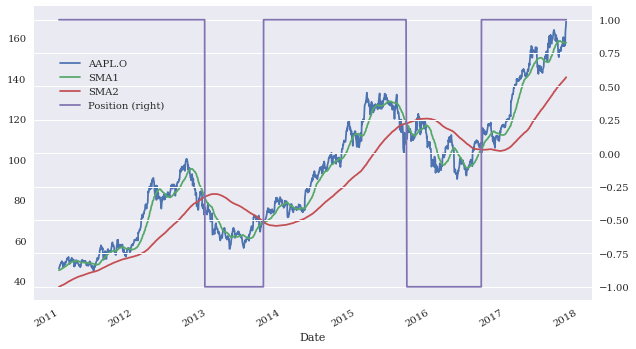

In [14]:
ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

#### Vectorized Backtesting

In [15]:
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))

In [16]:
data['Strategy'] = data['Position'].shift(1) * data['Returns']

In [17]:
data.round(4).head()

,AAPL.O,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2010-12-31,46.0800,45.2810,37.1207,1,NaN,NaN
2011-01-03,47.0814,45.3497,37.1862,1,0.0215,0.0215
2011-01-04,47.3271,45.4126,37.2525,1,0.0052,0.0052
2011-01-05,47.7142,45.4661,37.3223,1,0.0081,0.0081
2011-01-06,47.6757,45.5226,37.3921,1,-0.0008,-0.0008


In [18]:
data.dropna(inplace=True)

In [19]:
np.exp(data[['Returns', 'Strategy']].sum())

Returns     3.668406
Strategy    5.306802
dtype: float64

In [20]:
data[['Returns', 'Strategy']].std() * 252 ** 0.5

Returns     0.252947
Strategy    0.252763
dtype: float64

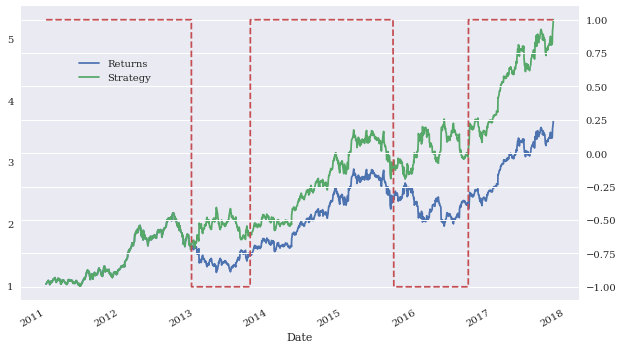

In [21]:
ax = data[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

#### Optimization

In [22]:
sma1 = range(20, 61, 4)
sma2 = range(180, 281, 10)

In [23]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    results = results.append(pd.DataFrame(
        {'SMA1': SMA1, 'SMA2': SMA2,
         'MARKET': perf['Returns'],
         'STRATEGY': perf['Strategy'],
         'OUT': perf['Strategy'] - perf['Returns']},
         index=[0]), ignore_index=True)

In [24]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      121 non-null    int64  
 1   SMA2      121 non-null    int64  
 2   MARKET    121 non-null    float64
 3   STRATEGY  121 non-null    float64
 4   OUT       121 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


In [25]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.246631,6.552273,2.305642
39,32,240,3.694406,5.989309,2.294903
59,40,220,3.853897,5.976137,2.122240
46,36,200,3.721010,5.834923,2.113913
55,40,180,4.177810,6.262625,2.084815
70,44,220,3.853897,5.908175,2.054279
101,56,200,3.721010,5.770906,2.049896


### Random Walk Hypothesis

In [26]:
symbol = '.SPX'

In [27]:
data = pd.DataFrame(raw[symbol])

In [28]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data[symbol].shift(lag)
    cols.append(col)

In [30]:
data.head(7)

,.SPX,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-04,1132.99,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.52,1132.99,NaN,NaN,NaN,NaN
2010-01-06,1137.14,1136.52,1132.99,NaN,NaN,NaN
2010-01-07,1141.69,1137.14,1136.52,1132.99,NaN,NaN
2010-01-08,1144.98,1141.69,1137.14,1136.52,1132.99,NaN
2010-01-11,1146.98,1144.98,1141.69,1137.14,1136.52,1132.99
2010-01-12,1136.22,1146.98,1144.98,1141.69,1137.14,1136.52


In [31]:
data.dropna(inplace=True)

### Linear OLS Regression

#### The Data

In [32]:
raw = pd.read_csv('/content/drive/My Drive/Python_for_Finance/data/tr_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()

In [33]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [34]:
symbol = 'EUR='

In [35]:
data = pd.DataFrame(raw[symbol])

In [36]:
data['returns'] = np.log(data / data.shift(1))

In [37]:
data.dropna(inplace=True)

In [38]:
data['direction'] = np.sign(data['returns']).astype(int)

In [39]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


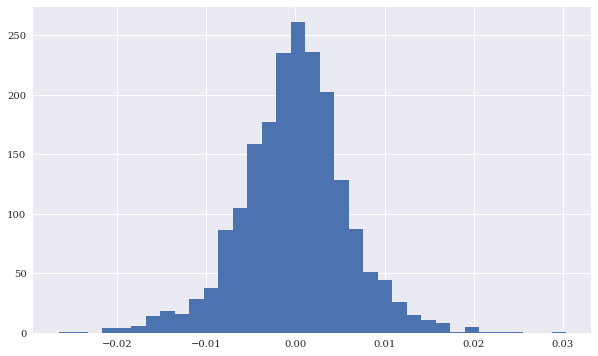

In [40]:
data['returns'].hist(bins=35, figsize=(10, 6));

In [41]:
lags = 2

In [42]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [43]:
create_lags(data)

In [44]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [45]:
data.dropna(inplace=True)

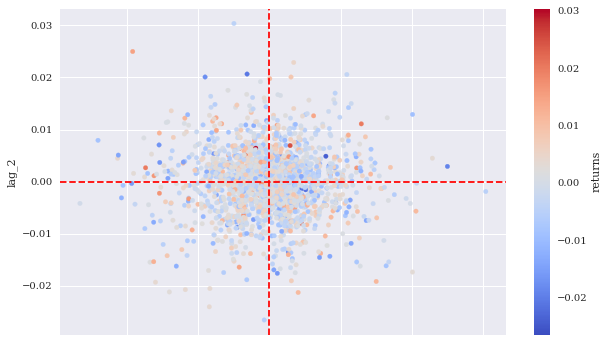

In [46]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');

#### Regression

In [47]:
model = LinearRegression()

In [48]:
data['pos_ols_1'] = model.fit(data[cols], 
                              data['returns']).predict(data[cols])

In [49]:
data['pos_ols_2'] = model.fit(data[cols], 
                              data['direction']).predict(data[cols])

In [50]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-07,-0.000202,-0.004063
2010-01-08,0.000046,0.043384
2010-01-11,-0.000310,-0.019115
2010-01-12,-0.000143,-0.042655
2010-01-13,0.000007,0.005976


In [51]:
data[['pos_ols_1', 'pos_ols_2']] = np.where( data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [52]:
data['pos_ols_1'].value_counts()

-1    1605
 1     364
Name: pos_ols_1, dtype: int64

In [53]:
data['pos_ols_2'].value_counts()

 1    1231
-1     738
Name: pos_ols_2, dtype: int64

In [54]:
(data['pos_ols_1'].diff() != 0).sum()

701

In [55]:
(data['pos_ols_2'].diff() != 0).sum()

789

In [56]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [57]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [58]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.807938
strat_ols_1    1.345052
strat_ols_2    1.418594
dtype: float64

In [59]:
(data['direction'] == data['pos_ols_1']).value_counts()

True     989
False    980
dtype: int64

In [60]:
(data['direction'] == data['pos_ols_2']).value_counts()

True     1023
False     946
dtype: int64

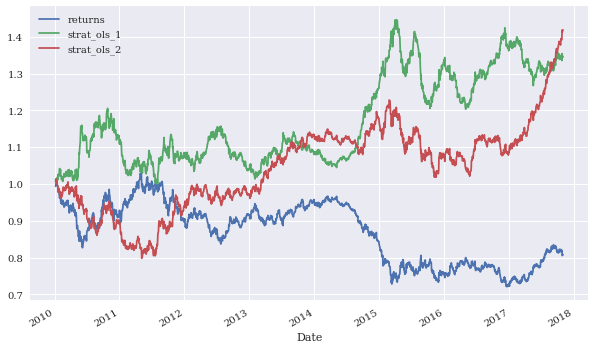

In [61]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### Clustering

In [62]:
model = KMeans(n_clusters=2, random_state=0)

In [63]:
model.fit(data[cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [64]:
data['pos_clus'] = model.predict(data[cols])

In [65]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)

In [66]:
data['pos_clus'].values

array([ 1, -1,  1, ..., -1,  1,  1])

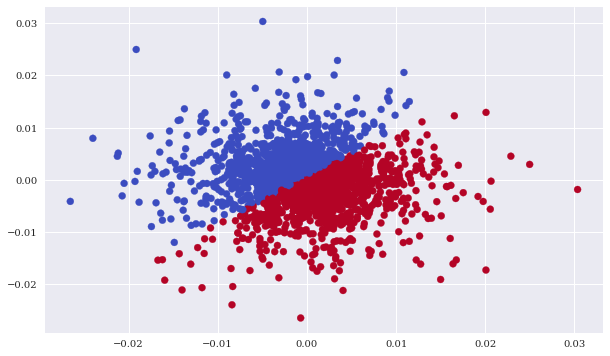

In [67]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1], c=data['pos_clus'], cmap='coolwarm');

In [68]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [69]:
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.807938
strat_clus    0.707421
dtype: float64

In [70]:
(data['direction'] == data['pos_clus']).value_counts()

False    1007
True      962
dtype: int64

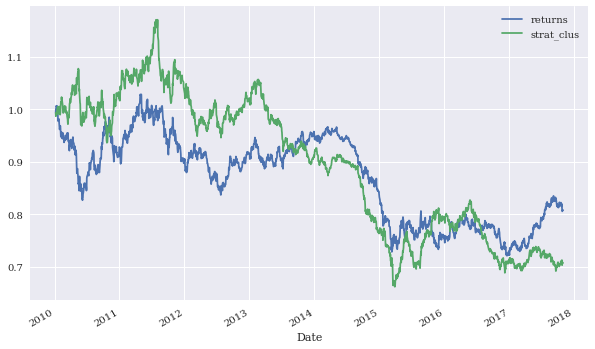

In [71]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### Frequency Approach

In [72]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)

In [73]:
create_bins(data)

In [74]:
data[cols_bin + ['direction']].head()

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1
2010-01-13,0,1,1


In [75]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           221
                       0             4
                       1           236
           1          -1           240
                       1           268
1          0          -1           250
                       0             1
                       1           258
           1          -1           259
                       0             4
                       1           228
dtype: int64

In [76]:
res = grouped['direction'].size().unstack(fill_value=0)

In [77]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [78]:
res.style.apply(highlight_max, axis=1)

In [79]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)

In [81]:
(data['direction'] == data['pos_freq']).value_counts()

True     1021
False     948
dtype: int64

In [82]:
data['strat_freq'] = data['pos_freq'] * data['returns']

In [83]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.807938
strat_freq    1.087601
dtype: float64

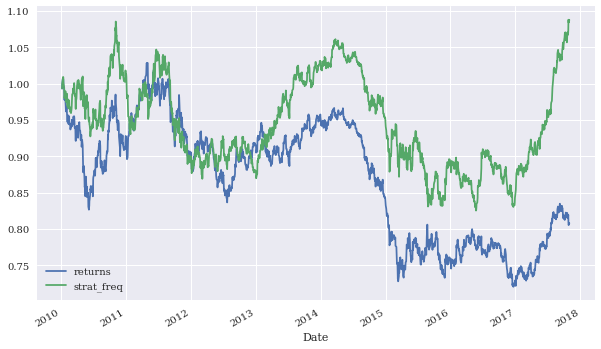

In [84]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### Classification

#### Two Binary Features

In [85]:
C = 1

In [86]:
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
    }

In [87]:
def fit_models(data):
    mfit = {model: models[model].fit(data[cols_bin],
                                     data['direction'])
    for model in models.keys()}

In [88]:
fit_models(data)

In [89]:
def derive_positions(data):
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [90]:
derive_positions(data)

In [91]:
def evaluate_strats(data):
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

In [92]:
evaluate_strats(data)

In [93]:
sel.insert(1, 'strat_freq')

In [94]:
data[sel].sum().apply(np.exp)

returns           0.807938
strat_freq        1.087601
strat_log_reg     1.320000
strat_gauss_nb    1.320000
strat_svm         1.087601
dtype: float64

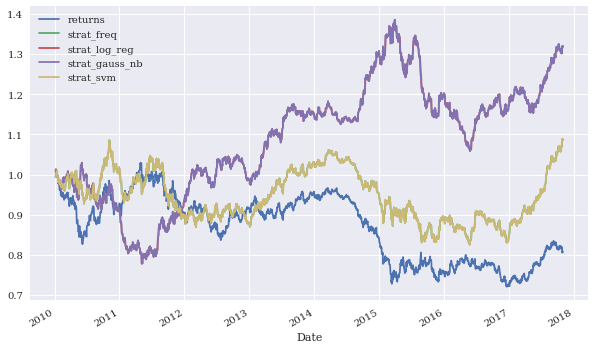

In [95]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

#### Five Binary Features

In [96]:
data = pd.DataFrame(raw[symbol])

In [97]:
data['returns'] = np.log(data / data.shift(1))

In [98]:
data['direction'] = np.sign(data['returns'])

In [99]:
lags = 5
create_lags(data)
data.dropna(inplace=True)

In [100]:
create_bins(data)
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [101]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,1,1,0,1,0
2010-01-13,0,1,1,0,1
2010-01-14,1,0,1,1,0
2010-01-15,0,1,0,1,1
2010-01-19,0,0,1,0,1


In [102]:
data.dropna(inplace=True)

In [103]:
fit_models(data)

In [104]:
derive_positions(data)

In [105]:
evaluate_strats(data)

In [106]:
data[sel].sum().apply(np.exp)

returns           0.802315
strat_log_reg     1.124849
strat_gauss_nb    1.124849
strat_svm         2.650562
dtype: float64

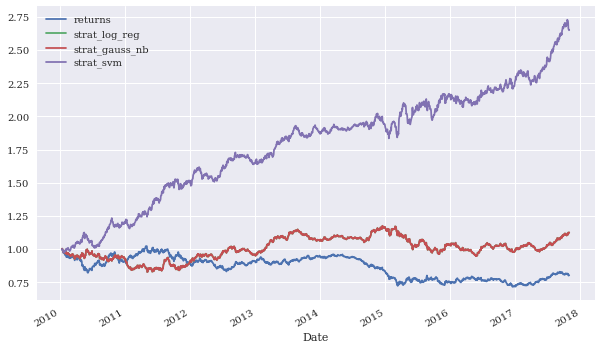

In [107]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

#### Five Digitized Features

In [108]:
mu = data['returns'].mean()
v = data['returns'].std()

In [109]:
bins = [mu - v, mu, mu + v]
bins

[-0.00613895454184234, -0.00011203142095872109, 0.005914891699924898]

In [110]:
create_bins(data, bins)

In [111]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-19,0,1,2,1,3


In [112]:
fit_models(data)

In [113]:
derive_positions(data)

In [114]:
evaluate_strats(data)

In [115]:
data[sel].sum().apply(np.exp)

returns           0.802315
strat_log_reg     1.290282
strat_gauss_nb    1.341964
strat_svm         5.877609
dtype: float64

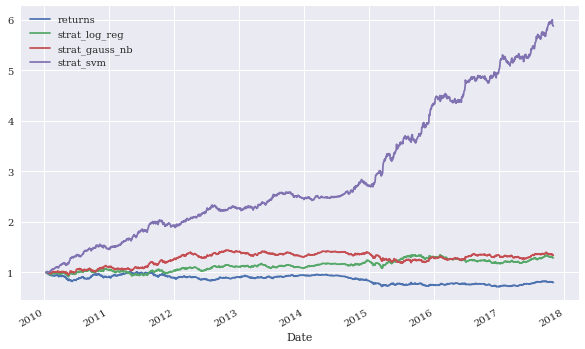

In [116]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

#### Sequential Train-Test Split

In [117]:
split = int(len(data) * 0.5)

In [118]:
train = data.iloc[:split].copy()

In [119]:
fit_models(train)

In [120]:
test = data.iloc[split:].copy()

In [121]:
derive_positions(test)

In [122]:
evaluate_strats(test)

In [123]:
test[sel].sum().apply(np.exp)

returns           0.851979
strat_log_reg     0.943480
strat_gauss_nb    0.911414
strat_svm         0.919531
dtype: float64

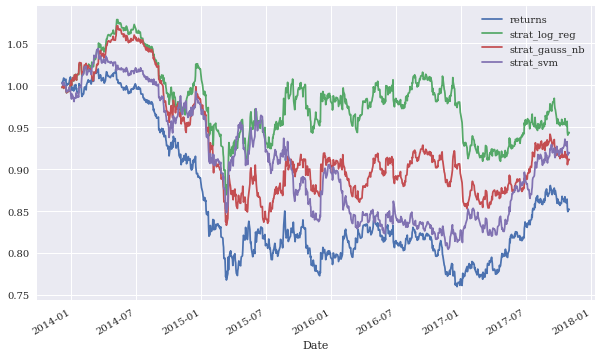

In [124]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

#### Randomized Train-Test Split

In [125]:
train, test = train_test_split(data, test_size=0.5, shuffle=True, random_state=100)

In [126]:
train = train.copy().sort_index()

In [127]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-20,1,0,1,2,1


In [128]:
test = test.copy().sort_index()

In [129]:
fit_models(train)

In [130]:
derive_positions(test)

In [131]:
evaluate_strats(test)

In [132]:
test[sel].sum().apply(np.exp)

returns           0.847855
strat_log_reg     0.981150
strat_gauss_nb    1.102309
strat_svm         0.948384
dtype: float64

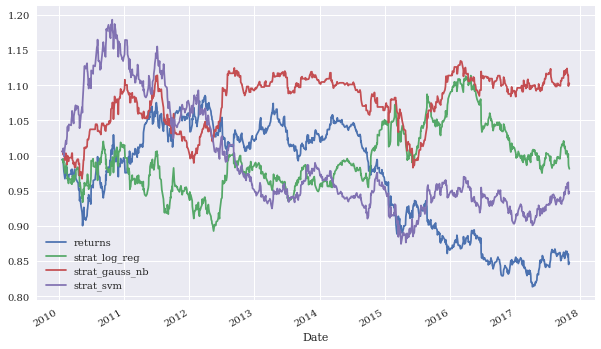

In [133]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

### Deep Neural Networks

#### DNNs with scikit-learn

In [134]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=2 * [250], random_state=1)

In [135]:
%time model.fit(data[cols_bin], data['direction'])

CPU times: user 21.2 s, sys: 17.5 s, total: 38.7 s
Wall time: 19.7 s


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[250, 250], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [137]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [138]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [140]:
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns          0.802315
strat_dnn_sk    45.288856
dtype: float64

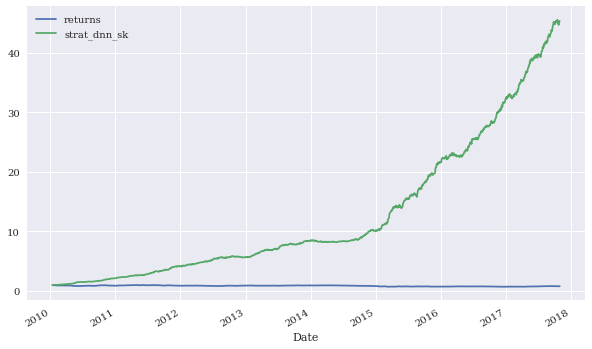

In [141]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [142]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [143]:
train = train.copy().sort_index()

In [144]:
test = test.copy().sort_index()

In [145]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500, 
                      hidden_layer_sizes=3 * [500], random_state=1)

In [146]:
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 2min 51s, sys: 1min 47s, total: 4min 38s
Wall time: 2min 21s


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[500, 500, 500], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [147]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [148]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

In [149]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         0.847855
strat_dnn_sk    0.990599
dtype: float64

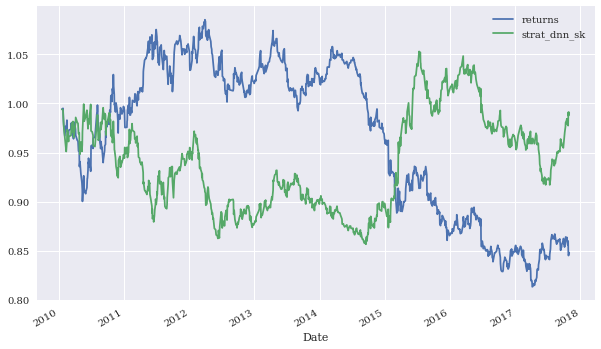

In [150]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

#### DNNs with TensorFlow

TensorFlow 버전 문제로 생략